# Imports

In [54]:
import numpy as np
import pandas as pd 
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Import Data 

In [34]:
ticker = yf.Ticker("AAPL")

df = ticker.history(period="1y")  # 1 an d'historique
print(df)

                                 Open        High         Low       Close  \
Date                                                                        
2024-11-15 00:00:00-05:00  225.380660  225.898323  223.260260  223.986969   
2024-11-18 00:00:00-05:00  224.235845  228.705635  224.156203  226.993378   
2024-11-19 00:00:00-05:00  225.958032  229.123722  225.639481  227.252182   
2024-11-20 00:00:00-05:00  227.033178  228.894754  224.872950  227.968948   
2024-11-21 00:00:00-05:00  227.849499  229.123735  224.693774  227.491119   
...                               ...         ...         ...         ...   
2025-11-10 00:00:00-05:00  268.959991  273.730011  267.459991  269.429993   
2025-11-11 00:00:00-05:00  269.809998  275.910004  269.799988  275.250000   
2025-11-12 00:00:00-05:00  275.000000  275.730011  271.700012  273.470001   
2025-11-13 00:00:00-05:00  274.109985  276.700012  272.089996  272.950012   
2025-11-14 00:00:00-05:00  271.049988  275.959991  269.600006  272.410004   

In [35]:
prices = df['Close']

<Axes: xlabel='Date'>

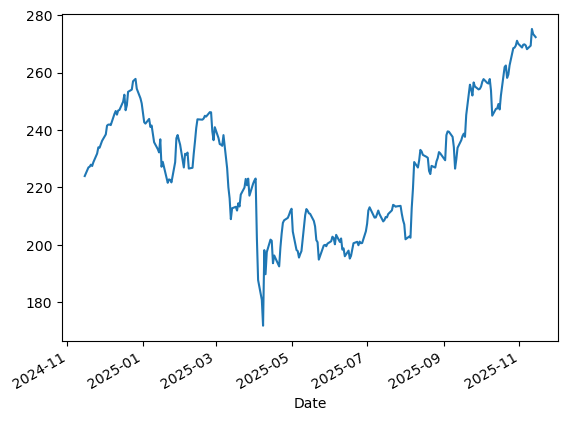

In [36]:
prices.plot()

In [42]:
print(np.std(prices)/100)

0.21890561779631781


In [37]:
def price_option(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_price = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

    return call_price

In [40]:
apple_option = price_option(prices[0],270,1,0.05,np.std(prices)/100)
print(apple_option)

8.472590194359192


/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1922/2496579041.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apple_option = price_option(prices[0],270,1,0.05,np.std(prices)/100)


In [59]:
def delta_BS(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

In [66]:
delta_value = []
hedge = []
dates = []
call_price = []

n = len(prices)

for date, val in prices.items():
    position = prices.index.get_loc(date)
    T = (n - position) / n   # time to maturity normalisé

    delta_value.append(
        delta_BS(val, 270, 0.05, np.std(prices)/100, T)
    )
    delta = delta_BS(val, 270, 0.05, np.std(prices)/100, T)
    call_price += [price_option(val,270,T,0.05,np.std(prices)/100)]
    dates += [date]
    hedge += [delta * val]

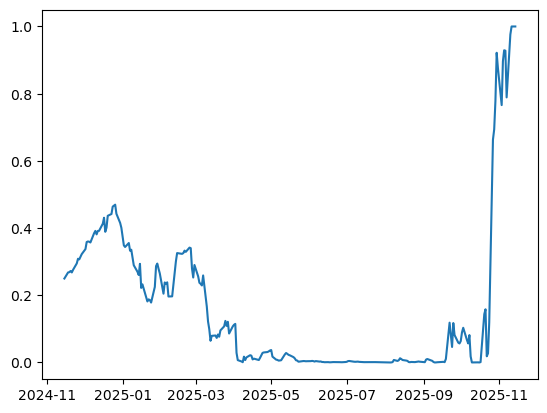

In [67]:
plt.plot(dates, delta_value)
plt.show()

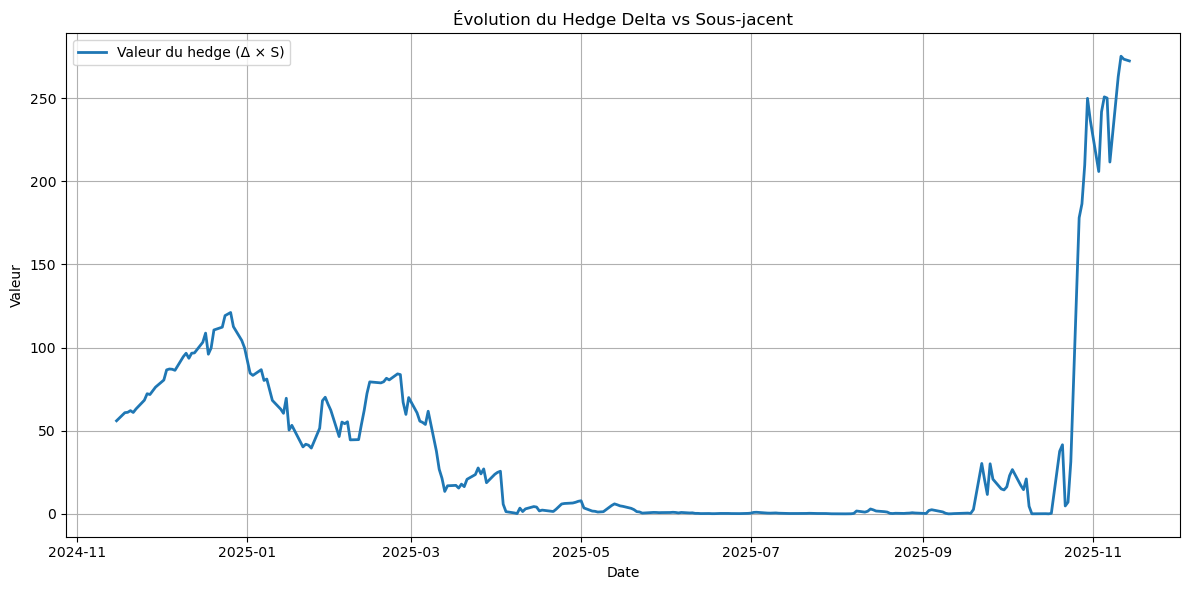

In [83]:
plt.figure(figsize=(12, 6))

plt.plot(dates, hedge, label="Valeur du hedge (Δ × S)", linewidth=2)
# plt.plot(dates, delta_value, label="Delta", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Valeur")
plt.title("Évolution du Hedge Delta vs Sous-jacent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
df = pd.DataFrame({
    "Price": prices.values,
    "Delta": delta_value
}, index=dates)

# Payoff du call à maturité
K = 270
df["Payoff"] = np.maximum(df["Price"].iloc[-1] - K, 0)

# Variations du sous-jacent
df["dS"] = df["Price"].diff()

# Hedge PNL : - ∑ delta_t * dS_{t+1}
df["HedgePNL"] = -(df["Delta"].shift(1) * df["dS"])
df["HedgePNL"].fillna(0, inplace=True)

# PNL cumulé du hedge
df["CumHedgePNL"] = df["HedgePNL"].cumsum()

# Portefeuille delta hedgé
df["PNL_Hedged"] = df["CumHedgePNL"] + df["Payoff"]

# Benchmark : long stock
df["PNL_LongStock"] = df["Price"] - df["Price"].iloc[0]


/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1922/2033620682.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["HedgePNL"].fillna(0, inplace=True)


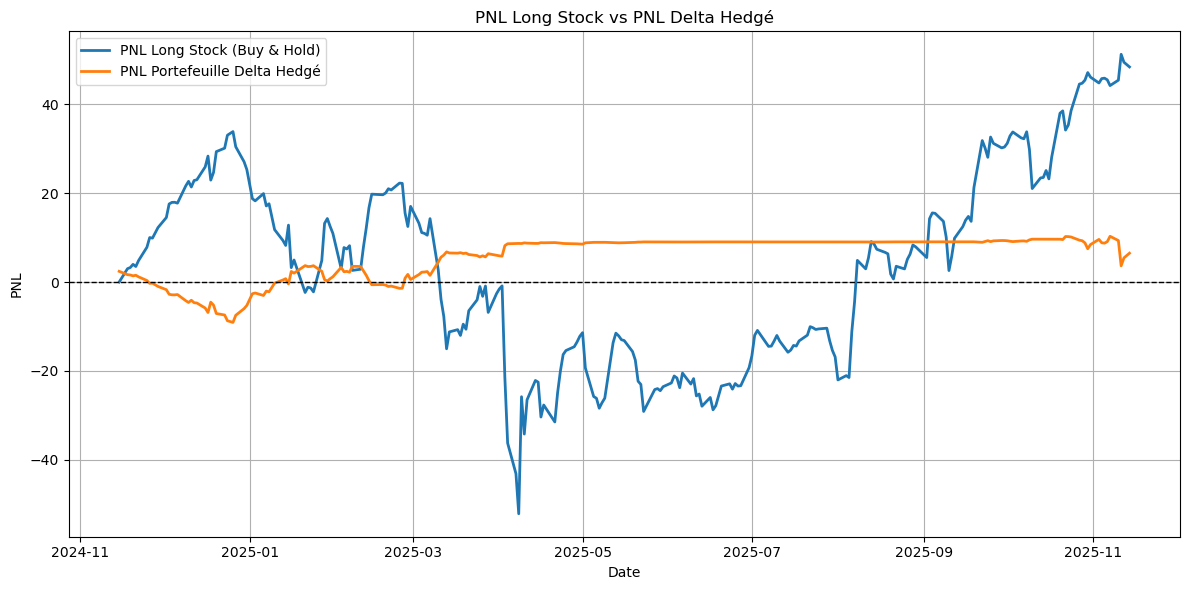

In [75]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["PNL_LongStock"], label="PNL Long Stock (Buy & Hold)", linewidth=2)
plt.plot(df.index, df["PNL_Hedged"], label="PNL Portefeuille Delta Hedgé", linewidth=2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("PNL Long Stock vs PNL Delta Hedgé")
plt.xlabel("Date")
plt.ylabel("PNL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
df = pd.DataFrame({
    "Price": prices.values,
    "Delta": delta_value
}, index=dates)

K = 270

# Payoff du call à maturité
df["Payoff"] = np.maximum(df["Price"].iloc[-1] - K, 0)

# Variation du sous-jacent
df["dS"] = df["Price"].diff()

# Flux long delta (on multiplie par la variation du prix)
df["LongDeltaFlow"] = df["Delta"].shift(1) * df["dS"]
df["LongDeltaFlow"].fillna(0, inplace=True)

df["CumLongDelta"] = df["LongDeltaFlow"].cumsum()

# PNL final = hedging + payoff (perdu)
df["PNL_LongDeltaShortCall"] = df["CumLongDelta"] - df["Payoff"]

df["PNL_LongStock"] = df["Price"] - df["Price"].iloc[0]

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_1922/2886225229.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["LongDeltaFlow"].fillna(0, inplace=True)


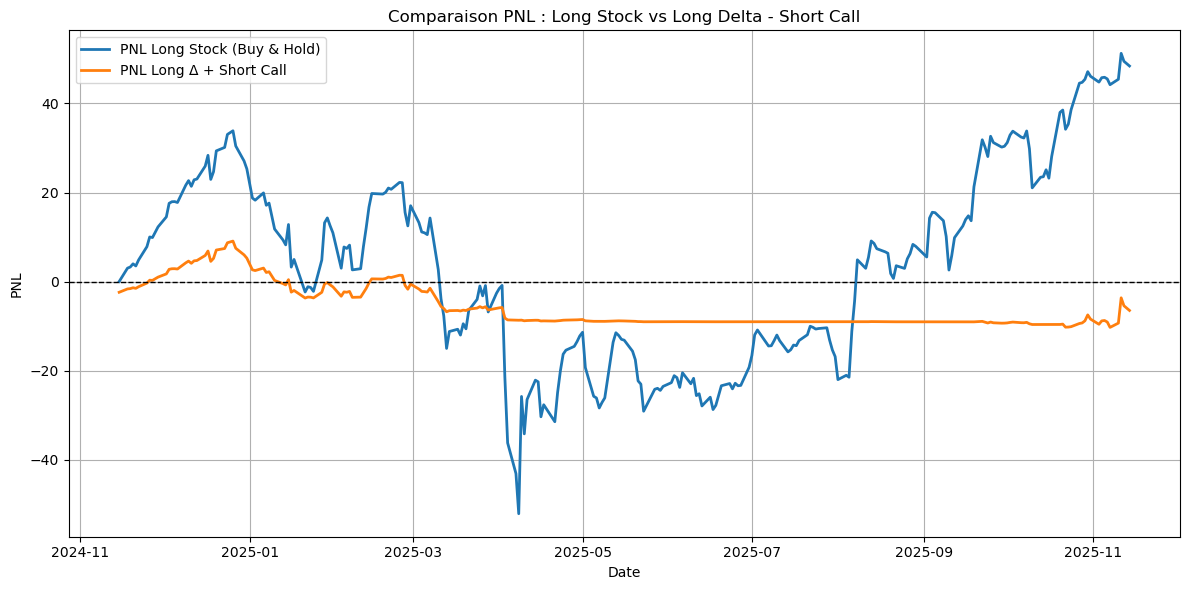

In [80]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["PNL_LongStock"], 
         label="PNL Long Stock (Buy & Hold)", linewidth=2)

plt.plot(df.index, df["PNL_LongDeltaShortCall"], 
         label="PNL Long Δ + Short Call", linewidth=2)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Comparaison PNL : Long Stock vs Long Delta - Short Call")
plt.xlabel("Date")
plt.ylabel("PNL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()